N.B: Please change path names before running.

In [1]:
!pip install --quiet bnlp_toolkit
!pip install git+https://github.com/csebuetnlp/normalizer

  Cloning https://github.com/csebuetnlp/normalizer to /tmp/pip-req-build-1_z47ozh
  Running command git clone --filter=blob:none --quiet https://github.com/csebuetnlp/normalizer /tmp/pip-req-build-1_z47ozh
  Resolved https://github.com/csebuetnlp/normalizer to commit d80c3c484e1b80268f2b2dfaf7557fe65e34f321
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for normalizer: filename=normalizer-0.0.1-py3-none-any.whl size=6885 sha256=2bda7247e73e927ea1e9b72544aaa38a8d4aee47317722f734cde8eef998f87d
  Stored in directory: /tmp/pip-ephem-wheel-cache-nscjefje/wheels/2e/79/9c/cd96d490298305d51d2da11484bb2c25fd1f759a6906708282
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186468 sha256=8337e9fbc4984b9f1fc863127b75349eba8ff3a9

In [2]:
import os
import ast
import re
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bnlp import BasicTokenizer
from normalizer import normalize


dataset-1

In [3]:
def adjust_label(label):
    """
    Adjust labels for our task. 
    PERSON token label is converted to PER label and other labels to O. As we only need person name entity token for the task.
    """
    per_label=["B-PERSON", "I-PERSON", "U-PERSON", "L-PERSON", "B-PER", "I-PER"]
    new_per_label= ["B-PER", "I-PER", "B-PER", "I-PER",  "B-PER", "I-PER"]
    ll= []
    for l in label:
        if l in per_label:
            ll.append(new_per_label[per_label.index(l)])

        else:
            ll.append('O')
    return ll

def readfile(filename):
    """ Part of this code is taken from- https://github.com/Rifat1493/Bengali-NER/blob/01656468c4e6e31dd6aff4cb42be1dc751a1abcf/src/prepro.py#L5
    """
    '''
    reads file (for first dataset)
    input:
    filename: name of the file.
    returns : DataFame containing sentence and corresponding labels
    sentences:(list of sentence) 'আশঙ্কাজনক অবস্থায় উপজেলা স্বাস্থ্য কমপ্লেক্সে নেওয়ার পথেই তাঁর মৃত্যু হয় ।',
    labels:(list of label) ['O', 'O', 'B-ORG', 'I-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'O']
    '''
    f = open(filename, encoding="utf-8")
    sentences = []
    sentence = []
    labels= []
    label= []
    for line in f:
        if len(line)==0 or line.startswith('-DOCSTART') or line[0]=="\n" or line[1]=="\n":
            if len(sentence) > 0:
                sentence= " ".join(sentence)
                sentences.append(sentence)
                labels.append(label)
                sentence = []
                label= []
            continue
        
        splits = line.split('\t')
        if (splits[-1]=='\n'):
            continue
        sentence.append(splits[0])
        label.append(splits[-1].split("\n")[0]) # remove extra "\n"

    if len(sentence) >0: # for last sentence
        sentence= " ".join(sentence)
        sentences.append(sentence)
        labels.append(label)
        sentence = []
        label= []
    
    f.close()

    df= pd.DataFrame(columns=["sentences", "labels"])
    df['sentences']= sentences
    df['labels']= labels
    df['labels']= df['labels'].apply(lambda x: adjust_label(x))
    df['sentences']= df['sentences'].apply(lambda x: normalize(x))
    return df

def readfile2(filename):
    """
    Reads file of the second dataset (jsonl). 
    """
    df= pd.read_json(filename, lines= True, encoding= 'utf-8')
    df.rename(columns= {0:"sentences", 1: "labels"}, inplace= True)
    
    df['sentences']= df['sentences'].apply(lambda x: normalize(x))
    df['labels']= df['labels'].apply(lambda x: adjust_label(x))
    
    return df

In [4]:
train_path1= "/kaggle/input/bangla-ner-task/Dataset_1/Input/train_data.txt"
test_path1= "/kaggle/input/bangla-ner-task/Dataset_1/Input/test_data.txt"
data_path2= "/kaggle/input/bangla-ner-task/bangla_NER_2.jsonl"

In [7]:
dataset1_train= readfile(train_path1)
dataset1_test= readfile(test_path1)
dataset2= readfile2(data_path2)

In [8]:
display(dataset1_train)
display(dataset1_test)
display(dataset2)

,sentences,labels
0,"কী কারণে তাঁদের মধ্যে ঝামেলা হয়েছে , তা জানি ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,আশঙ্কাজনক অবস্থায় উপজেলা স্বাস্থ্য কমপ্লেক্সে...,"[O, O, O, O, O, O, O, O, O, O, O]"
2,খুলনার দিঘলিয়া উপজেলার বারাকপুর মধ্যপাড়ায় গ...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,পুলিশের পিটুনিতে কেসমত আলীর মৃত্যু হয়েছে বলে ...,"[O, O, B-PER, I-PER, O, O, O, O, O, O, O]"
4,"তবে পুলিশ বলছে , ওই ব্যক্তি পুলিশ দেখে পড়ে গে...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
...,...,...
4607,বিকেএসপিতে এখন তিন-চারটা মাঠ ।,"[O, O, O, O, O]"
4608,সেখানে যদি আমরা চারটা দলকে কয়েকটা ম্যাচ খেলাই...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4609,সেটা যে খেলোয়াড়দের মধ্যেও ইতিবাচক প্রভাব ফেল...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4610,নয়তো নিজেদের ঘায়েল করার অস্ত্রটা যে বাংলাদেশ...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


,sentences,labels
0,উন্নয়নের বিস্ময় বাংলাদেশ বাংলাদেশের অগ্রগতি ...,"[O, O, O, O, O, O, O, O, O]"
1,অর্থনীতি ও আর্থসামাজিক বেশির ভাগ সূচকে বাংলাদে...,"[O, O, O, O, O, O, O, O, O, O, O, O]"
2,নিম্ন আয়ের দেশগুলোকে ছাড়িয়েছে তো অনেক আগেই ।,"[O, O, O, O, O, O, O, O]"
3,আন্তর্জাতিক মুদ্রা তহবিল ( আইএমএফ ) গত সপ্তাহে...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,সবাইকে অন্তর্ভুক্ত করে প্রবৃদ্ধি অর্জনের ক্ষেত...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
...,...,...
1945,১৩ আগস্ট কোপা লিবার্তাদোরেসের ফাইনালের দ্বিতীয...,"[O, O, O, O, O, O, O, O]"
1946,"দক্ষিণ আমেরিকার সেরা ক্লাব কারা , জানা যাবে এদ...","[O, O, O, O, O, O, O, O, O, O]"
1947,২৪ আগস্ট আরেকটি বিশ্বকাপ ফাইনাল ।,"[O, O, O, O, O, O]"
1948,কানাডার মন্ট্রিয়লে হবে মেয়েদের অনূর্ধ্ব-২০ ব...,"[O, O, O, O, O, O, O, O]"


,sentences,labels
0,অগ্রণী ব্যাংকের জ্যেষ্ঠ কর্মকর্তা পদে নিয়োগ প...,"[O, O, O, O, O, O, O, O, O, O, O, O]"
1,ব্যাংকের চেয়ারম্যানও এ অভিযোগের সত্যতা স্বীকা...,"[O, O, O, O, O, O, O, O]"
2,আজ শুক্রবার বিকেল চারটা থেকে পাঁচটা পর্যন্ত এক...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
3,এ ছাড়া কয়েকটি পরীক্ষাকেন্দ্রে ছাত্রলীগের নেত...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
4,ব্যাংকের চেয়ারম্যান ও ঢাকা বিশ্ববিদ্যালয়ের ই...,"[O, O, O, O, O, O, O, O, B-PER, I-PER, I-PER, ..."
...,...,...
3540,গাজীপুরের নতুন বাজার এলাকায় গতকাল দুপুরে মেঘন...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3541,গন্তব্যস্থলের ঠিকানা লেখা ছিল 'হেল অ্যান্ড হার...,"[O, O, O, O, O, O, O, O, O, O, O, O, O]"
3542,কুমিল্লা বিশ্ববিদ্যালয়ের জন্য একটি বাস উপহার ...,"[O, O, O, O, O, O, O, O, O, O, O]"
3543,"বিশ্ববিদ্যালয়ের পরিবহন শাখা সূত্রে জানা গেছে,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


[Text(0, 0, '4612'), Text(0, 0, '1950'), Text(0, 0, '3545')]

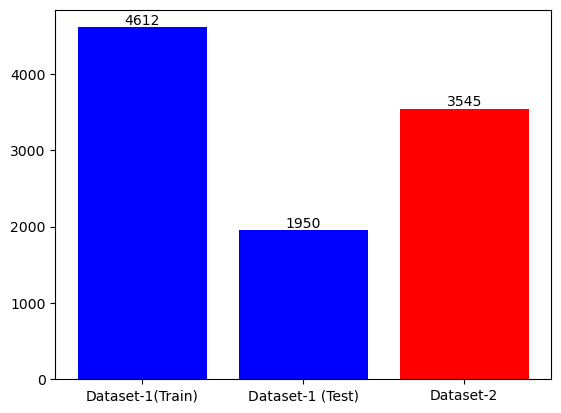

In [9]:
fig, ax = plt.subplots()
bars = ax.bar(['Dataset-1(Train)', 'Dataset-1 (Test)', 'Dataset-2'], height= [len(dataset1_train), len(dataset1_test), len(dataset2)], color= ['b', 'b', 'r'])

ax.bar_label(bars)

In [10]:

def check_common_entry(df1, df2):
    """
    Checks wheather the given dataset has common entries
    """
    b_tokenizer= BasicTokenizer()
    list1= [tuple(b_tokenizer.tokenize(txt)) for txt in df1['sentences']]
    list2= [tuple(b_tokenizer.tokenize(txt)) for txt in df2['sentences']]
    common= set(list1).intersection(set(list2))
    
    return common

- Dataset 1 train and test has 81 sentences in common which may lead to data leakage

In [11]:
common1= check_common_entry(dataset1_train, dataset2) #set(list11).intersection(set(list2))
print(f"No of Common sentences between Dataset 1 and Dataset 2: {len(common1)}")
common2= check_common_entry(dataset1_train, dataset1_test)#set(list11).intersection(set(list12))
print(f"No of Common sentences between Dataset 1 train and test: {len(common2)}")
common3= check_common_entry(dataset1_test, dataset2) #set(list12).intersection(set(list2))
print(f"No of Common sentences between Dataset 1 test and Dataset2: {len(common3)}")

No of Common sentences between Dataset 1 and Dataset 2: 4
No of Common sentences between Dataset 1 train and test: 81
No of Common sentences between Dataset 1 test and Dataset2: 3


In [12]:

def remove_common_entries(df, common):
    """
    removes common entries from the given dataset.
    df: from where common entrires has to remove
    common: entries that found in common. (from check_common_entry function)
    """
    common= [" ".join(txt) for txt in common]
    indexes= [df[df['sentences'] == com].index for com in common]
    index= []
    if len(indexes)>0:
        for idx in indexes:
            try:
                index.append(idx[0])
            except:
                pass
    try:
        df= df.drop(index).reset_index(drop= True)
    except:
        pass
    
    print(f"Total {len(index)} of data was removed from the given dataset.")
    
    return df

def remove_erroneous_entries(df):
    """
    Error entries are those which have inequal no of labels or words.
    
    """
    temp_df= df
    b_tokenizer= BasicTokenizer()
    temp_df['len_labels']= temp_df['labels'].apply(lambda x: len(x))
    temp_df['len_words']= temp_df['sentences'].apply(lambda x: len(b_tokenizer.tokenize(x)))
    
    error_=[]
    for i in range(len(temp_df)):
        if temp_df['len_labels'][i] != temp_df['len_words'][i]:
            error_.append(i)
    print(f"{len(error_)} no of data was detected as erroneous and discarded.")
    df= df.drop(error_).reset_index(drop= True)
    return df

In [13]:
dataset1_train= remove_erroneous_entries(dataset1_train)
dataset2= remove_erroneous_entries(dataset2)

1019 no of data was detected as erroneous and discarded.
174 no of data was detected as erroneous and discarded.


In [14]:
dataset1_test= remove_common_entries(dataset1_test, common2)
dataset1_test

Total 68 of data was removed from the given dataset.


,sentences,labels
0,উন্নয়নের বিস্ময় বাংলাদেশ বাংলাদেশের অগ্রগতি ...,"[O, O, O, O, O, O, O, O, O]"
1,অর্থনীতি ও আর্থসামাজিক বেশির ভাগ সূচকে বাংলাদে...,"[O, O, O, O, O, O, O, O, O, O, O, O]"
2,নিম্ন আয়ের দেশগুলোকে ছাড়িয়েছে তো অনেক আগেই ।,"[O, O, O, O, O, O, O, O]"
3,আন্তর্জাতিক মুদ্রা তহবিল ( আইএমএফ ) গত সপ্তাহে...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,সবাইকে অন্তর্ভুক্ত করে প্রবৃদ্ধি অর্জনের ক্ষেত...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
...,...,...
1877,১৩ আগস্ট কোপা লিবার্তাদোরেসের ফাইনালের দ্বিতীয...,"[O, O, O, O, O, O, O, O]"
1878,"দক্ষিণ আমেরিকার সেরা ক্লাব কারা , জানা যাবে এদ...","[O, O, O, O, O, O, O, O, O, O]"
1879,২৪ আগস্ট আরেকটি বিশ্বকাপ ফাইনাল ।,"[O, O, O, O, O, O]"
1880,কানাডার মন্ট্রিয়লে হবে মেয়েদের অনূর্ধ্ব-২০ ব...,"[O, O, O, O, O, O, O, O]"


,sentences,labels,len_labels,len_words,per_tag
0,আশঙ্কাজনক অবস্থায় উপজেলা স্বাস্থ্য কমপ্লেক্সে...,"[O, O, O, O, O, O, O, O, O, O, O]",11,11,0
1,খুলনার দিঘলিয়া উপজেলার বারাকপুর মধ্যপাড়ায় গ...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",27,27,1
2,পুলিশের পিটুনিতে কেসমত আলীর মৃত্যু হয়েছে বলে ...,"[O, O, B-PER, I-PER, O, O, O, O, O, O, O]",11,11,1
3,"তবে পুলিশ বলছে , ওই ব্যক্তি পুলিশ দেখে পড়ে গে...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O]",14,14,0
4,"কেসমতের পরিবার , এলাকাবাসী ও পুলিশ সূত্রে জানা...","[B-PER, O, O, O, O, O, O, O, O, O, O, O, O, O,...",28,28,1


[Text(0, 0, '818'), Text(0, 0, '2775')]

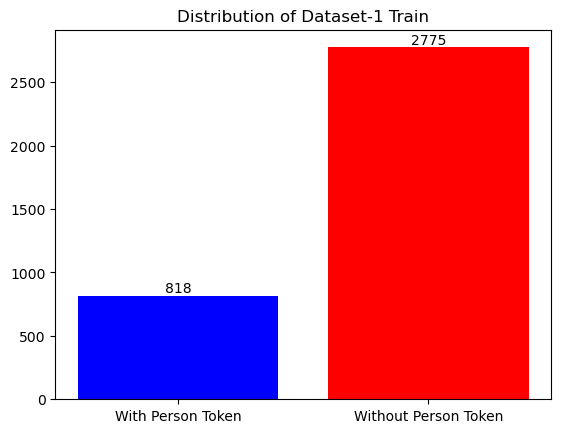

In [15]:
dataset1_train['per_tag']= dataset1_train['labels'].apply(lambda x: 1 if x.count("B-PER")>0 else 0)
# label= dataset2['']
display(dataset1_train.head())
sum(dataset1_train['per_tag'])

fig, ax = plt.subplots()
bars = ax.bar(['With Person Token', 'Without Person Token'], height= [sum(dataset1_train['per_tag']), len(dataset1_train)-sum(dataset1_train['per_tag'])], color= ['b', 'r'])
plt.title("Distribution of Dataset-1 Train")
ax.bar_label(bars)

,sentences,labels,per_tag
0,উন্নয়নের বিস্ময় বাংলাদেশ বাংলাদেশের অগ্রগতি ...,"[O, O, O, O, O, O, O, O, O]",0
1,অর্থনীতি ও আর্থসামাজিক বেশির ভাগ সূচকে বাংলাদে...,"[O, O, O, O, O, O, O, O, O, O, O, O]",0
2,নিম্ন আয়ের দেশগুলোকে ছাড়িয়েছে তো অনেক আগেই ।,"[O, O, O, O, O, O, O, O]",0
3,আন্তর্জাতিক মুদ্রা তহবিল ( আইএমএফ ) গত সপ্তাহে...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",0
4,সবাইকে অন্তর্ভুক্ত করে প্রবৃদ্ধি অর্জনের ক্ষেত...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O]",0


[Text(0, 0, '580'), Text(0, 0, '1302')]

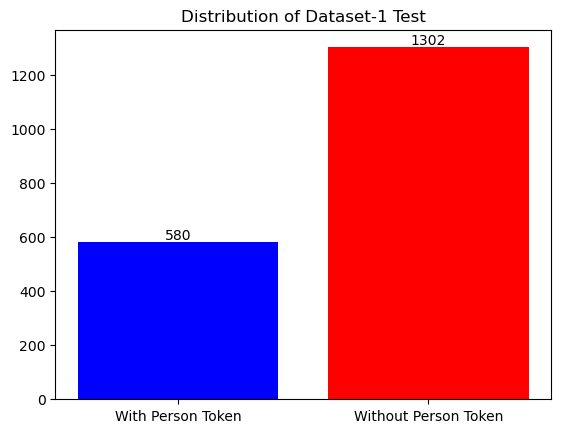

In [16]:
dataset1_test['per_tag']= dataset1_test['labels'].apply(lambda x: 1 if x.count("B-PER")>0 else 0)
# label= dataset2['']
display(dataset1_test.head())
sum(dataset1_test['per_tag'])

fig, ax = plt.subplots()
bars = ax.bar(['With Person Token', 'Without Person Token'], height= [sum(dataset1_test['per_tag']), len(dataset1_test)-sum(dataset1_test['per_tag'])], color= ['b', 'r'])
plt.title("Distribution of Dataset-1 Test")
ax.bar_label(bars)

,sentences,labels,len_labels,len_words,per_tag
0,অগ্রণী ব্যাংকের জ্যেষ্ঠ কর্মকর্তা পদে নিয়োগ প...,"[O, O, O, O, O, O, O, O, O, O, O, O]",12,12,0
1,ব্যাংকের চেয়ারম্যানও এ অভিযোগের সত্যতা স্বীকা...,"[O, O, O, O, O, O, O, O]",8,8,0
2,আজ শুক্রবার বিকেল চারটা থেকে পাঁচটা পর্যন্ত এক...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O]",14,14,0
3,এ ছাড়া কয়েকটি পরীক্ষাকেন্দ্রে ছাত্রলীগের নেত...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]",16,16,0
4,ব্যাংকের চেয়ারম্যান ও ঢাকা বিশ্ববিদ্যালয়ের ই...,"[O, O, O, O, O, O, O, O, B-PER, I-PER, I-PER, ...",27,27,1


[Text(0, 0, '1122'), Text(0, 0, '2249')]

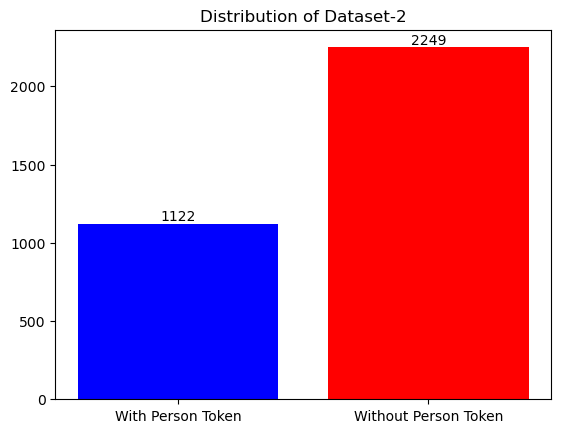

In [17]:
dataset2['per_tag']= dataset2['labels'].apply(lambda x: 1 if x.count("B-PER")>0 else 0)
# label= dataset2['']
display(dataset2.head())
sum(dataset2['per_tag'])

fig, ax = plt.subplots()
bars = ax.bar(['With Person Token', 'Without Person Token'], height= [sum(dataset2['per_tag']), len(dataset2)-sum(dataset2['per_tag'])], color= ['b', 'r'])
plt.title("Distribution of Dataset-2")
ax.bar_label(bars)

In [18]:
dataset= pd.concat([dataset2, dataset1_train], axis= 0).reset_index(drop= True)


,sentences,labels,len_labels,len_words,per_tag
0,অগ্রণী ব্যাংকের জ্যেষ্ঠ কর্মকর্তা পদে নিয়োগ প...,"[O, O, O, O, O, O, O, O, O, O, O, O]",12,12,0
1,ব্যাংকের চেয়ারম্যানও এ অভিযোগের সত্যতা স্বীকা...,"[O, O, O, O, O, O, O, O]",8,8,0
2,আজ শুক্রবার বিকেল চারটা থেকে পাঁচটা পর্যন্ত এক...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O]",14,14,0
3,এ ছাড়া কয়েকটি পরীক্ষাকেন্দ্রে ছাত্রলীগের নেত...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]",16,16,0
4,ব্যাংকের চেয়ারম্যান ও ঢাকা বিশ্ববিদ্যালয়ের ই...,"[O, O, O, O, O, O, O, O, B-PER, I-PER, I-PER, ...",27,27,1


[Text(0, 0, '1940'), Text(0, 0, '5024')]

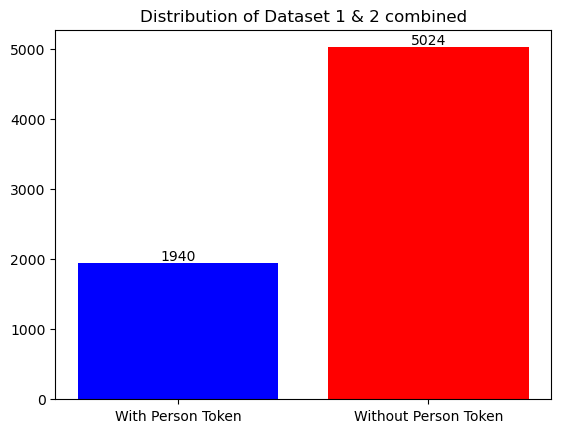

In [19]:

dataset['per_tag']= dataset['labels'].apply(lambda x: 1 if x.count("B-PER")>0 else 0)
# label= dataset2['']
display(dataset.head())
sum(dataset['per_tag'])

fig, ax = plt.subplots()
bars = ax.bar(['With Person Token', 'Without Person Token'], height= [sum(dataset['per_tag']), len(dataset)-sum(dataset['per_tag'])], color= ['b', 'r'])
plt.title("Distribution of Dataset 1 & 2 combined")
ax.bar_label(bars)

In [20]:
# Dataset is imbalanced.
## Undersampling
import random
index_0= dataset[dataset['per_tag']==0].index
index_1= dataset[dataset['per_tag']==1].index
len(index_0), len(index_1)


if len(index_0) > len(index_1):
    index = [i for i in index_0]
#     print(index)
    index_n= random.sample(index, k= len(index_0) - len(index_1))
#     print(index_n)

In [21]:
def downsampling(df):
    random.seed(20)
    index_0= df[df['per_tag']==0].index # indexes of negative samples (without Name entity)
    index_1= df[df['per_tag']==1].index # indexes of positive samples (with name entity)
    index_n= None
    if len(index_0) > len(index_1):
        index = [i for i in index_0]
        index_n= random.sample(index, k= len(index_0) - len(index_1))
    if index_n is not None:
        df= df.drop(index_n).reset_index(drop= True)
    
    return df

def upsampling(df, upsample_size= 0.5):
    """upsamples minority class data.
    """
    random.seed(20)
    df['per_tag']= df['labels'].apply(lambda x: 1 if x.count("B-PER") > 0 else 0)
    index_0= df[df['per_tag']==0].index # indexes of negative samples (without Name entity)
    index_1= df[df['per_tag']==1].index # indexes of positive samples (with name entity)
    index_add= None
    
    if len(index_0) > len(index_1): 
        # upsampling class 1 
        n_diff= len(index_0) > len(index_1)
        index = [i for i in index_1]
        index_add= random.sample(index, k= int(n_diff*upsample_size) if n_diff < len(index_1) else  int(len(index_1)*upsample_size) )
    elif len(index_1) > len(index_0):
        # upsampling class 0
        n_diff= len(index_1) > len(index_0)
        index = [i for i in index_0]
        index_add= random.sample(index, k= int(n_diff*upsample_size) if n_diff < len(index_0) else  int(len(index_0)*upsample_size))

    if index_add is not None:
        temp_df= df.iloc[index_add].reset_index(drop= True)
        df= pd.concat([df, temp_df], axis= 0).reset_index(drop= True)
    
    return df


### Modeling

In [23]:
!pip install transformers

In [24]:
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset, DataLoader#, Dataset
from torch.optim import AdamW


import transformers 
from transformers import (
    AutoModel,
    AutoConfig,
    AutoTokenizer,
    BertTokenizer,
    AutoModelForSequenceClassification,
    AutoModelForTokenClassification
)

%env TOKENIZERS_PARALLELISM=true

from sklearn.model_selection import StratifiedKFold


# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

env: TOKENIZERS_PARALLELISM=true


#### Configs

In [25]:
class CONFIG:
    train= False # #True
    debug= False # #True
    seed= 20
    n_folds= 3
    num_epochs= 50
    label_names=['O', 'B-PER', 'I-PER']
    num_labels= len(label_names)
    model_name= "csebuetnlp/banglabert_large" #"nafi-zaman/celloscope-28000-ner-banglabert-finetuned"  #"csebuetnlp/banglabert" #  #"nafi-zaman/mbert-finetuned-ner" #
    model_checkpoint= "/kaggle/input/hishab-ner/best_model_0.bin"
    max_length= 126
    
    dataset_no= 3 #1: Dataset-1 only # 2: Dataset-2 only # 3: Combined dataset
    do_normalize= True
    do_downsampling= True
    do_upsampling= True
    upsample_size= 1
    train_batch_size= 8
    valid_batch_size= 16
    test_batch_size= 16
    num_workers= 2
    device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    gradient_accumulation_steps= 1
    learning_rate= 2e-5
    weight_decay= 1e-2
    scheduler= "CosineAnnealingWarmRestarts" #"CosineAnnealingWarmRestarts" #"linear"
    T_max= 500
    T_0= 500
    min_lr= 1e-7
    
    eps = 1e-6
    betas= [0.9, 0.999]
    
if CONFIG.debug:
    CONFIG.n_folds= 2
    CONFIG.num_epochs=2
    CONFIG.dataset_size= 300
    

Loading prepossed data for dataloader

In [26]:
if CONFIG.dataset_no == 1:
    dataset= dataset1_train
elif CONFIG.dataset_no == 2:
    dataset= dataset2
else:
    dataset= pd.concat([dataset2, dataset1_train], axis= 0).reset_index(drop= True)

dataset= remove_erroneous_entries(dataset)

if CONFIG.do_upsampling:
    dataset= upsampling(dataset, upsample_size= CONFIG.upsample_size)
if CONFIG.do_downsampling:
    dataset= downsampling(dataset)
# dataset['sentences']= dataset['sentences'].apply(lambda x: normalize(x))

0 no of data was detected as erroneous and discarded.


In [27]:
if CONFIG.debug:
    data= dataset[['sentences', 'labels']][: CONFIG.dataset_size]
else:
    data= dataset[['sentences', 'labels']]

data['per_tag']= data['labels'].apply(lambda x: 1 if x.count("B-PER")>0 else 0)

In [28]:
## checking every data have exact number of labels corresponding to its words 
b_tokenizer= BasicTokenizer()
data['len_labels']= data['labels'].apply(lambda x: len(x))
data['len_words']= data['sentences'].apply(lambda x: len(b_tokenizer.tokenize(x)))

In [33]:
## spliting data for train and validation

skf= StratifiedKFold(n_splits= CONFIG.n_folds, random_state= CONFIG.seed, shuffle= True)

for fold, (train_index, val_index) in enumerate(skf.split(X= data, y= data['per_tag'])):
    data.loc[val_index, 'fold']= int(fold)
    
data['fold']= data['fold'].astype(int)

data= data[['sentences', 'labels', 'fold']]

display(data.groupby('fold').size())

Models

In [37]:
label_names=['O', 'B-PER', 'I-PER']
id2label= {}
label2id= {}
for i, label in enumerate(label_names):
    id2label[i]= label
    label2id[label] = i

display(id2label)
display(label2id)

{0: 'O', 1: 'B-PER', 2: 'I-PER'}

{'O': 0, 'B-PER': 1, 'I-PER': 2}

In [39]:
# tokenizer
tokenizer = AutoTokenizer.from_pretrained(CONFIG.model_name)

In [40]:
def align_labels_with_tokens(tokens, labels):
    new_labels= []
    word_ids= tokens.word_ids()
    previous_word_id= None
    for word_id in word_ids:
        if word_id is None:
            label= -100
        elif word_id != previous_word_id:
            label= label2id[labels[word_id]]
        else:
            label= -100 if word_id is None else label2id[labels[word_id]] # [CLS] has token id= 101. [PAD] token id= 0 ## tokenizer.pad_token_id
        previous_word_id= word_id
        new_labels.append(label)
    
    """-100 is used for all of the speciall token ['[CLS], ['SEP'], [PAD]'], which will help to compute loss for slot filling"""
    
    return new_labels

In [44]:
from torch.utils.data import DataLoader, Dataset

class CustomDataset(Dataset):
    def __init__(self, df, tokenizer, cfg):
        self.df= df
        self.cfg= cfg
        self.tokenizer= tokenizer
        self.max_length= self.cfg.max_length
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text= self.df.sentences[index]
        labels= self.df.labels[index]
        inputs= self.tokenizer(text,
                               truncation= True,
#                                add_special_tokens= True,
                               max_length= self.max_length,
                               padding= True
                               )
        
        new_labels= align_labels_with_tokens(inputs, labels)
        
        return {
            "input_ids": inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            'targets': new_labels            
        }
    


In [46]:
class Collate:
    def __init__(self, tokenizer):
        self.tokenizer= tokenizer
    
    def __call__(self, batch):
        output= dict()
        output["input_ids"] = [sample['input_ids'] for sample in batch]
        output["attention_mask"] = [sample["attention_mask"] for sample in batch]
        output['targets'] = [sample['targets'] for sample in batch]
        
        batch_max= max([len(ids) for ids in output['input_ids']])
        
        # dynamic padding
        if self.tokenizer.padding_side == "right":
            output["input_ids"] = [ids + (batch_max - len(ids))*[self.tokenizer.pad_token_id] for ids in output['input_ids']]
            output['attention_mask']= [mask + (batch_max - len(mask))*[0] for mask in output['attention_mask']]
            output['targets']= [target + (batch_max - len(target))*[-100] for target in output['targets']]
        else:
            output["input_ids"] = [(batch_max - len(ids))*[self.tokenizer.pad_token_id] + ids for ids in output['input_ids']]
            output['attention_mask']= [(batch_max - len(mask))*[0] + mask for mask in output['attention_mask']]
            output['targets']= [(batch_max - len(target))*[-100] + target for target in output['targets']]
        
        # convert array to tensor
        output["input_ids"] = torch.tensor(output['input_ids'], dtype= torch.long)
        output["attention_mask"] = torch.tensor(output['attention_mask'], dtype= torch.long)
        output['targets'] = torch.tensor(output['targets'], dtype=torch.long)#
        
        return output
    

collate_fn= Collate(tokenizer)

In [48]:
def prepare_loader(df, tokenizer,fold, cfg):
    df_train= df[df.fold != fold].reset_index(drop= True) # 2 fold out of 3 fold is used as training data, and 1 fold for validation.
    df_valid= df[df.fold == fold].reset_index(drop= True)
    valid_labels = df_valid['labels'].values
    
    # converting dataFrame to dataset.
    train_dataset= CustomDataset(df_train, tokenizer, cfg)
    valid_dataset= CustomDataset(df_valid, tokenizer, cfg)
    
    train_loader= DataLoader(train_dataset, 
                             batch_size= cfg.train_batch_size, 
                             collate_fn= collate_fn, #merges a list of samples to form a mini-batch of Tensors
                             num_workers= cfg.num_workers, # how many subprocesses to use for data loading
                             shuffle= True, 
                             pin_memory= True,
                             drop_last= False, )
    
    valid_loader= DataLoader(valid_dataset, 
                            batch_size= cfg.valid_batch_size,
                            collate_fn= collate_fn, 
                            num_workers= cfg.num_workers,
                            shuffle= False,
                            pin_memory= True, #If True, the data loader will copy Tensors into device/CUDA pinned memory before returning them
                            drop_last= False,
                            )
    
    return train_loader, valid_loader

In [51]:
class NER_MODEL(nn.Module):
    def __init__(self, model_name= None, cfg= CONFIG):
        super(NER_MODEL, self).__init__()
        self.cfg= cfg
        self.num_labels= self.cfg.num_labels
        if model_name != None:
            self.model_name= model_name
        else:
            self.model_name= self.cfg.model_name
            
        self.model_config= AutoConfig.from_pretrained(self.model_name, output_hidden_states= True)
        self.model= AutoModel.from_pretrained(self.model_name, config= self.model_config)
        
        self.dropout= nn.Dropout(p= 0.2)
        self.linear= nn.Linear(self.model_config.hidden_size, self.num_labels)
        
    def forward(self, input_ids, attention_mask, targets= None):
        
        outputs= self.model(input_ids,
                            attention_mask= attention_mask,
                            )
        
        sequence_output= outputs[0]
#         pooled_output= outputs[1]

#         entity_logits= self.dropout(sequence_output)
        entity_logits= sequence_output #self.dropout(sequence_output)
        entity_logits= self.linear(entity_logits)
        
        return entity_logits


In [54]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=f139194adbfe6698794fce9b50c9f22a055cc7378a01b94d3eed94264c74632d
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [58]:
from datasets import load_metric
metric = load_metric("seqeval")

def compute_metrics(logits, labels):
    predictions = np.argmax(logits.detach().cpu().numpy(), axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[ label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return all_metrics['overall_f1']


def token_loss_fn(logits, labels, attention_mask= None):
    loss_fn= nn.CrossEntropyLoss(ignore_index= -100) # for ignoring special tokens
    num_labels= CONFIG.num_labels
    
    if attention_mask is not None:
        mask= attention_mask.view(-1) == 1 #mask for keeping the effective part
        active_logits= logits.view(-1, num_labels)[mask]
        active_labels= labels.view(-1)[mask]
#         print(active_logits.size(), active_labels.size())
        entity_loss= loss_fn(active_logits, active_labels)
        
    else:
        entity_loss= loss_fn(logits.view(-1, num_labels), labels.view(-1))
    
    return entity_loss

In [59]:
def fetch_scheduler(optimizer):
    if CONFIG.scheduler == "CosineAnnealingLR":
        scheduler= lr_scheduler.CosineAnnealingLR(optimizer, T_max= CONFIG.T_max, eta_min= CONFIG.min_lr)
    elif CONFIG.scheduler == "CosineAnnealingWarmRestarts":
        scheduler= lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0= CONFIG.T_0, eta_min= CONFIG.min_lr)
    elif CONFIG.scheduler== "linear":
        scheduler= lr_scheduler.LinearLR(optimizer, start_factor= 0.01, end_factor= 1.0, total_iters= 100)
    elif CONFIG.scheduler == None:
        return None

    return scheduler

In [60]:
def train_one_epoch(model, dataloader, optimizer, scheduler, fold, epoch, device= CONFIG.device):
    model.train()

    dataset_size= 0
    running_loss= 0.0
    score= []
    
    progress_bar= tqdm(enumerate(dataloader), total= len(dataloader))
    steps= len(dataloader)
    for step, data in progress_bar:
        ids= data['input_ids'].to(device, dtype= torch.long)
        masks= data['attention_mask'].to(device, dtype= torch.long)
        targets= data['targets'].to(device, dtype= torch.long)
        
        batch_size= ids.size(0)
        outputs= model(ids, masks)
        loss= token_loss_fn(outputs, targets, attention_mask= masks)
        f1_score= compute_metrics(logits= outputs, labels= targets)
        score.append(f1_score)
        if CONFIG.gradient_accumulation_steps > 1:
            loss= loss/ CONFIG.gradient_accumulation_steps
        
        loss.backward()
        ## Gradient Accumulation
        if (step + 1) % CONFIG.gradient_accumulation_steps == 0 or step == steps:
            
            optimizer.step() #Performs a single optimization step (parameter update)
            
            # clear out the gradients of all Variables 
            # in this optimizer (i.e. W, b)
            optimizer.zero_grad()
            
            if scheduler is not None:
                scheduler.step()
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        epoch_loss= running_loss/ dataset_size
        epoch_f1_score= np.mean(score)
        
        progress_bar.set_postfix(Epoch= epoch,
                                 Train_loss= epoch_loss,
                                 F1_Score= epoch_f1_score,
                                 LR= optimizer.param_groups[0]['lr'])
    
    return epoch_loss, epoch_f1_score #

In [61]:
def valid_one_epoch(model, dataloader, epoch, device= CONFIG.device):
    model.eval()
    
    dataset_size= 0
    running_loss= 0.0
    score= []
    
    progress_bar= tqdm(enumerate(dataloader), total= len(dataloader))
    steps= len(dataloader)
    
    for step, data in progress_bar:
        ids= data['input_ids'].to(device, dtype= torch.long)
        masks= data['attention_mask'].to(device, dtype= torch.long)
        targets= data['targets'].to(device, dtype= torch.long)
        
        batch_size= ids.size(0)
        
        with torch.no_grad():
            outputs= model(ids, masks)
            loss= token_loss_fn(outputs, targets, attention_mask= masks)
            f1_score= compute_metrics(logits= outputs, labels= targets)
        
        score.append(f1_score)
        
        if CONFIG.gradient_accumulation_steps > 1:
            loss= loss/ CONFIG.gradient_accumulation_steps
        
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        epoch_loss= running_loss/ dataset_size
        epoch_f1_score= np.mean(score)
        
        progress_bar.set_postfix(Epoch= epoch,
                                 Valid_loss= epoch_loss,
                                 Valid_F1_Score= epoch_f1_score,
                                )
    return epoch_loss, epoch_f1_score #

In [62]:
import time
from collections import defaultdict
def training_loop(model, optimizer, scheduler, fold, num_epochs= CONFIG.num_epochs, patience= 3):
    
    start= time.time()
    best_loss= np.inf
    best_score= 0
    trigger_times= 0
    history= defaultdict(list)
    
    for epoch in range(1, num_epochs+1):
        train_epoch_loss, train_f1_score= train_one_epoch(model, train_loader, optimizer, scheduler, fold, epoch, CONFIG.device)
        valid_epoch_loss, valid_f1_score = valid_one_epoch(model, valid_loader, epoch, CONFIG.device)
        
        history['train_loss'].append(train_epoch_loss)
        history['valid_loss'].append(valid_epoch_loss)
        history['train_f1_score'].append(train_f1_score)
        history['valid_f1_score'].append(valid_f1_score)
        
        #####
        if  valid_f1_score >= best_score: #valid_epoch_loss #best_loss
            trigger_times= 0
            print(f"Vlaidation Score Improved {best_score} ---> {valid_f1_score}")
            best_score= valid_f1_score
            
            path= f"best_model_{fold}.bin"
            torch.save(model.state_dict(), path)
            print(f"Model saved to {path}")
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print("Early Stoping. \n")
                break
                
    time_elapsed= time.time() - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    
    return history, valid_epoch_loss, best_score



In [63]:
if CONFIG.train:
    fold_scores= []
    for fold in range(CONFIG.n_folds):
        torch.cuda.empty_cache()
        print(f"====== Fold: {fold} ======")

        # Create Dataloaders
        train_loader, valid_loader = prepare_loader(data, tokenizer, fold= fold, cfg= CONFIG)

        # Model
        model= NER_MODEL(cfg= CONFIG)
        model.to(device= CONFIG.device)

        # Optimizer & LR Scheduler
        optimizer= AdamW(model.parameters(), lr= CONFIG.learning_rate, weight_decay= CONFIG.weight_decay, eps= CONFIG.eps, betas= CONFIG.betas)
        scheduler= fetch_scheduler(optimizer)

        # run training
        history, epoch_loss, f1_score= training_loop(model, optimizer, scheduler, fold, CONFIG.num_epochs, patience= 5)#epoch_loss

        print("\n\n")
        print(f"Fold [{fold}] avg loss: {epoch_loss}\n")
        print(f"Fold [{fold}] avg score: {f1_score}\n")
        fold_scores.append(f1_score)
        
        if fold < CONFIG.n_folds-1:
            del model
        del train_loader, valid_loader

    print(f"====== xxxx ======")
    # print(f"Overall average scores: {np.mean(fold_scores, axis= 0)}")
    print(f"Overall score: {np.mean(np.mean(fold_scores, axis= 0))}")
    print(f"====== xxxx ======")


## Testing

In [64]:
from tqdm.auto import tqdm
def testing_loop(model, dataloader, device= CONFIG.device):
    model.eval()
    
    score= []
    
    progress_bar= tqdm(enumerate(dataloader), total= len(dataloader))
    steps= len(dataloader)
    
    for step, data in progress_bar:
        ids= data['input_ids'].to(device, dtype= torch.long)
        masks= data['attention_mask'].to(device, dtype= torch.long)
        targets= data['targets'].to(device, dtype= torch.long)
        
        batch_size= ids.size(0)
        
        with torch.no_grad():
            outputs= model(ids, masks)
            f1_score= compute_metrics(logits= outputs, labels= targets)
        
        score.append(f1_score)
        
        
        f1_score= np.mean(score)
        
        progress_bar.set_postfix(test_F1_Score= f1_score,)
    
    print(f"====== xxxx ======")
    # print(f"Overall average scores: {np.mean(fold_scores, axis= 0)}")
    print(f"Overall f1_score: {np.mean(np.mean(f1_score))}")
    print(f"====== xxxx ======")

    
    return f1_score #

In [66]:
test_df= readfile(test_path1)
test_data= remove_erroneous_entries(test_df)
# test_data['sentences']= test_data['sentences'].apply(lambda x: normalize(x))
test_dataset= CustomDataset(test_data, tokenizer, CONFIG)
test_loader= DataLoader(test_dataset, 
                        batch_size= CONFIG.test_batch_size,
                        collate_fn= collate_fn, 
                        num_workers= CONFIG.num_workers,
                        shuffle= False,
                        pin_memory= True, #If True, the data loader will copy Tensors into device/CUDA pinned memory before returning them
                        drop_last= False,
                        )

434 no of data was detected as erroneous and discarded.


In [67]:
model_paths= [
    "/kaggle/input/hishab-ner/best_model_0.bin",
    "/kaggle/input/hishab-ner/best_model_1.bin",
    "/kaggle/input/hishab-ner/best_model_2.bin"
    ]

In [68]:
model= NER_MODEL(cfg= CONFIG)
for i,model_path in enumerate(model_paths):
    model.load_state_dict(torch.load(model_path, map_location= CONFIG.device))
    model.to(CONFIG.device)
    print(f"Run testing for model {CONFIG.model_name}")
    f1_score= testing_loop(model, test_loader, device= CONFIG.device)
    print(f"Model {i} result: {f1_score}")

Some weights of the model checkpoint at csebuetnlp/banglabert_large were not used when initializing ElectraModel: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Run testing for model csebuetnlp/banglabert_large


  0%|          | 0/95 [00:00<?, ?it/s]

====== xxxx ======
Overall f1_score: 0.7957514889444895
====== xxxx ======
Model 0 result: 0.7957514889444895
Run testing for model csebuetnlp/banglabert_large


  0%|          | 0/95 [00:00<?, ?it/s]

====== xxxx ======
Overall f1_score: 0.7645387735869568
====== xxxx ======
Model 1 result: 0.7645387735869568
Run testing for model csebuetnlp/banglabert_large


  0%|          | 0/95 [00:00<?, ?it/s]

====== xxxx ======
Overall f1_score: 0.7848142078366168
====== xxxx ======
Model 2 result: 0.7848142078366168


## End to End Inference

In [69]:
def prediction(text, model, tokenizer, cfg= CONFIG):
    inputs= tokenizer.encode_plus(text, padding=True, truncation=True, return_tensors="pt")
    outputs= model(inputs['input_ids'].to(cfg.device), inputs['attention_mask'].to(cfg.device))
    outputs= outputs.detach().cpu().numpy().argmax(axis= -1)[0, 1:-1]
    return outputs

def inference_fn(text, model_name= None, model_checkpoint= None, cfg= CONFIG):
    # loading model and weights
    if model_name is not None:
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model= NER_MODEL(model_name= model_name, cfg= cfg)
    else:
        tokenizer = AutoTokenizer.from_pretrained(cfg.model_name)
        model= NER_MODEL(cfg= CONFIG)
        
    if model_checkpoint != None:
        model.load_state_dict(torch.load(model_checkpoint, map_location=  cfg.device))
    else:
        model.load_state_dict(torch.load(cfg.model_checkpoint, map_location=  cfg.device))
    
    model.to(cfg.device)
    ## processing inputs
    outputs=[]
    if type(text) == str:
        text= normaliz(text)
        output= prediction(text, model, tokenizer, cfg)
        outputs.append(output)
    elif type(text)== list:
        for txt in text:
            txt= normalize(txt)
            output= prediction(txt, model, tokenizer, cfg)
            outputs.append(output)      
    else:
        outputs= None
        print("Please give input in string format or list of strings")
    
    return outputs

In [72]:
def extract_spans(prediction):
    span_indices = [i for i, v in enumerate(prediction) if v != 0 ]
    span_list= []
    span= []
    # span_indices
    for i in range(len(span_indices)):
        if i == 0 or span_indices[i] != span_indices[i-1]+1:
            if span:
                span_list.append(span)

            span= [span_indices[i]]

        else:
            span.append(span_indices[i])
    if span:
        span_list.append(span)
    
    return span_list

def extract_names(text, span_list, tokenizer):
    name_list= []
    if len(span_list) > 0:
        for span in span_list:
            tokens= tokenizer(text)['input_ids'][1:-1][span[0]:span[-1]+1]
            name= normalize(tokenizer.decode(tokens))
            name_list.append(name)
        return name_list
    else:
        return None

def show_names(texts, predictions, tokenizer):
    if type(texts)== str:
        texts= [texts]
    for text, pred in zip(texts, predictions):
        span_list= extract_spans(pred)
        name_list= extract_names(text, span_list, tokenizer)
        print(f"Given Text: {text} \nExtracted Names: {name_list}")
    

In [73]:
model_path= model_paths[0]
texts=  "আন্তর্জাতিক অপরাধ ট্রাইব্যুনাল-১-এর চেয়ারম্যান বিচারপতি এ টি এম ফজলে কবীর অবসর নিয়েছেন ।" 
texts= ["আব্দুর রহিম নামের কাস্টমারকে একশ টাকা বাকি দিলাম",
       "আন্তর্জাতিক অপরাধ ট্রাইব্যুনাল-১-এর চেয়ারম্যান বিচারপতি এ টি এম ফজলে কবীর অবসর নিয়েছেন ।", 
       "ব্যাংকের চেয়ারম্যান ও ঢাকা বিশ্ববিদ্যালয়ের ইন্টারন্যাশনাল বিজনেস বিভাগের অধ্যাপক খন্দকার বজলুল হক প্রথম আলো ডটকমকে জানান, বিকেল তিনটা ৫০ মিনিটে তিনি এ ধরনের অভিযোগ পেয়েছেন।",
       "একই সঙ্গে অভিযোগ তদন্তে বিশ্ববিদ্যালয়ের কোষাধ্যক্ষ সায়েন উদ্দিনকে প্রধান করে পাঁচ সদস্যের কমিটি গঠন করা হয়েছে।",
      ]

outputs= inference_fn(texts, model_checkpoint= model_path, cfg= CONFIG)
show_names(texts, outputs, tokenizer)

Some weights of the model checkpoint at csebuetnlp/banglabert_large were not used when initializing ElectraModel: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Given Text: আব্দুর রহিম নামের কাস্টমারকে একশ টাকা বাকি দিলাম 
Extracted Names: ['আব্দুর রহিম']
Given Text: আন্তর্জাতিক অপরাধ ট্রাইব্যুনাল-১-এর চেয়ারম্যান বিচারপতি এ টি এম ফজলে কবীর অবসর নিয়েছেন । 
Extracted Names: ['এ টি এম ফজলে কবীর']
Given Text: ব্যাংকের চেয়ারম্যান ও ঢাকা বিশ্ববিদ্যালয়ের ইন্টারন্যাশনাল বিজনেস বিভাগের অধ্যাপক খন্দকার বজলুল হক প্রথম আলো ডটকমকে জানান, বিকেল তিনটা ৫০ মিনিটে তিনি এ ধরনের অভিযোগ পেয়েছেন। 
Extracted Names: ['অধ্যাপক খন্দকার বজলুল হক']
Given Text: একই সঙ্গে অভিযোগ তদন্তে বিশ্ববিদ্যালয়ের কোষাধ্যক্ষ সায়েন উদ্দিনকে প্রধান করে পাঁচ সদস্যের কমিটি গঠন করা হয়েছে। 
Extracted Names: ['সায়েন উদ্দিনকে']
